In [1]:
%matplotlib inline
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [2]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [3]:
def step1(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    match = np.array([0, 0, 178, 62, 71, 168, 187, 253, 16, 38, 149, 55, 226, 170, 26], dtype = np.uint8)
    match_extended = np.tile(match, int(rcv.shape[0]/len(match)))
    
    idx = np.argmax([np.mean(np.equal(np.packbits(np.roll(np.unpackbits(rcv), i)), match_extended)) for i in range(15 * 8)])
    
    to_write = np.packbits(np.roll(np.unpackbits(rcv), idx))
    
    with open("output2.data", "wb") as f:
        f.write(to_write)

In [4]:
def step2():
    process=subprocess.Popen(["python2", "BCH_Recoder.py"],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE)


    #time.sleep(10)

    # while os.stat("output.data").st_size < os.stat("orig_pinguim.bmp").st_size * 2:
    #     pass

    inputdata= b" "
    stdoutdata,stderrdata=process.communicate(input=inputdata)
    
    return

In [5]:
def step3(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    final = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    match_extended_final = np.tile(tx, int(final.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(final), np.unpackbits(match_extended_final))))

In [6]:
%%time
step1("output.data")

CPU times: user 1.7 s, sys: 469 ms, total: 2.17 s
Wall time: 2.17 s


In [7]:
%%time
step2()

CPU times: user 0 ns, sys: 4.74 ms, total: 4.74 ms
Wall time: 12 s


In [8]:
%%time
step3("output3.data")

CPU times: user 20.4 ms, sys: 7.07 ms, total: 27.5 ms
Wall time: 26.4 ms


0.0008326785714285467

In [9]:
get_SNR("output.txt"), step3("output3.data")

((3.5442453731343284, 0.40204622170349363), 0.0008326785714285467)

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER


In [10]:
a = """
((5.768470298507462, 0.2987775633295857), 6.607142857162351e-06)

((4.929100223880598, 0.3143828189816444), 5.51785714285602e-05)

((2.65316776119403, 0.4505079155294491), 0.5389667857142857)

((3.5442453731343284, 0.40204622170349363), 0.0008326785714285467)
"""

In [11]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [12]:
import math

In [13]:
10*math.log10(15/7)

3.3099321904142442

In [14]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [15]:
EbN0_range = np.load("Numpy vector refs/EbN0List.npy")

In [16]:
theory_de_bpsk = np.load("Numpy vector refs/theory_de-bpsk.npy")

In [17]:
simu_de_bpsk = np.load("Numpy vector refs/simu_de-bpsk.npy")

In [18]:
simu_de_bpsk_bch_15_7 = np.load("Numpy vector refs/simu_de-bpsk-bch-15-7-2.npy")

In [19]:
np.array(snr_avgs) + 10*math.log10(15/7)

array([9.07840249, 8.23903241, 5.96309995, 6.85417756])

In [20]:
EbN0_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

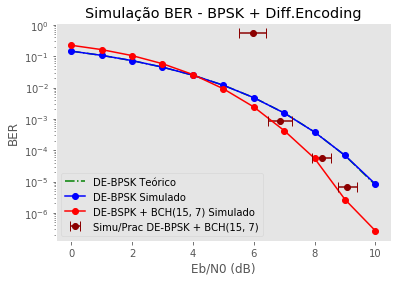

In [21]:
plt.style.use('ggplot')
plt.semilogy(EbN0_range, theory_de_bpsk, "g-.", label = "DE-BPSK Teórico")
plt.semilogy(EbN0_range, simu_de_bpsk, "b-o", label = "DE-BPSK Simulado")
plt.semilogy(EbN0_range, simu_de_bpsk_bch_15_7, "r-o", label = "DE-BSPK + BCH(15, 7) Simulado")
# plt.semilogy(np.array(snr_avgs) + 10 * math.log10(15/7), bers, "*", color = "darkred", label = "Simu/Prac DE-BPSK")
plt.errorbar(np.array(snr_avgs) + 10 * math.log10(15/7), bers, xerr = np.array(snr_stds), fmt = "o", color = "darkred", capsize = 5, label = "Simu/Prac DE-BPSK + BCH(15, 7)")

plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK + Diff.Encoding')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png")